In [1]:
import autograd.numpy as np
from autograd import grad 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, Perceptron, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

In [2]:
csv_training = 'Training.csv'
csv_test = 'Test.csv'

df_training = pd.read_csv(csv_training)
df_test = pd.read_csv(csv_test)

In [3]:
# thanks to chatGPT, the following function describes the dataset, taken
# from the Dartmouth College machine learning repository

import pandas as pd
import numpy as np

def dataset_summary(data):
    """
    Generate a brief summary of a dataset.

    Parameters:
    - data: Pandas DataFrame

    Returns:
    - summary: Pandas DataFrame
    """
    # Check if input is a Pandas DataFrame
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input must be a Pandas DataFrame.")

    # Basic information about the dataset
    num_rows, num_cols = data.shape

    # Summary statistics
    statistics = data.describe()

    # Number of missing values in each column
    missing_values = data.isnull().sum()

    # Number of unique values in each column
    unique_values = data.nunique()

    # Handling categorical columns separately
    categorical_columns = data.select_dtypes(include='category').columns
    categorical_summary = pd.DataFrame()  # Initialize an empty DataFrame

    # Check if there are any categorical columns before calling describe()
    if not categorical_columns.empty:
        categorical_summary = data[categorical_columns].describe()

    # Combine the information into a summary DataFrame
    summary = pd.DataFrame({
        'Data Type': data.dtypes,
        'Non-Null Count': data.count(),
        'Mean': statistics.loc['mean'],
        'Min': statistics.loc['min'],
        '25%': statistics.loc['25%'],
        '50% (Median)': statistics.loc['50%'],
        '75%': statistics.loc['75%'],
        'Max': statistics.loc['max'],
        'Missing Values': missing_values,
        'Unique Values': unique_values
    })

    # Add categorical summary to the main summary
    summary.loc[categorical_columns] = categorical_summary

    # Additional information
    summary['Number of Rows'] = num_rows
    summary['Number of Columns'] = num_cols

    return summary

# Example usage:
# Assuming you have a DataFrame named 'df_training'
summary_result = dataset_summary(df_training)
print(summary_result)


               Data Type  Non-Null Count          Mean          Min  \
asin              object         29189.0           NaN          NaN   
category          object         29189.0           NaN          NaN   
image             object           600.0           NaN          NaN   
reviewText        object         29189.0           NaN          NaN   
reviewTime        object         29189.0           NaN          NaN   
reviewerID        object         29189.0           NaN          NaN   
reviewerName      object         29185.0           NaN          NaN   
rr                 int64         29189.0  2.971907e+00          1.0   
style             object         15365.0           NaN          NaN   
summary           object         29184.0           NaN          NaN   
unixReviewTime     int64         29189.0  1.409661e+09  894758400.0   
verified            bool         29189.0           NaN          NaN   
vote             float64          6047.0  7.295353e+00          2.0   

     

### What does it contain?

The dataset contains information related to product reviews. Key columns include:

asin: Product identifier

category: Category of the product

image: Image related to the product

reviewText: Text of the product review

reviewTime: Time when the review was written

reviewerID: ID of the reviewer

reviewerName: Name of the reviewer

rr: Rating or review rating (the target variable)

style: Style information

summary: Summary or heading of the review

unixReviewTime: Unix timestamp of the review time

verified: Boolean indicating whether the review is verified

vote: Number of votes the review received

### What is your target variable?

The target variable is confidently identified as rr (review rating). This variable represents the rating given in a review and is likely the focus for analysis or potential machine learning tasks. If the goal is to predict or analyze review ratings, rr serves as the target variable for such tasks.







The only columns in the data that seem to give relevant, readily-processable information were columns 7 and 8 (indexed 6 and 7) which contained customer reviews and review summaries. Term Frequency - Inverse Document Frequency is an easy way to convert the text documents into numerical feature vectors, where each document is represented by a vector that contains the TF-IDF scores of the terms in the vocabulary.

In [4]:
#convert training and test sets to numpy arrays
x_array_training = df_training.to_numpy()
x_array_test = df_test.to_numpy()

#actual star rating for training
y = x_array_training[:,0]

#concatenate reviewer text and summary
x_raw_training = [str(i) + " " + str(j) for i, j in zip(x_array_training[:,6], x_array_training[:,7])]
x_raw_test = [str(i) + " " + str(j) for i, j in zip(x_array_test[:,5], x_array_test[:,6])]

#vectorizer reviews + summary for training
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), min_df = .001, max_df = 0.9, max_features = 10000)
x_train = vectorizer.fit_transform(x_raw_training)
x_test = vectorizer.transform(x_raw_test)

# Binary Classifiers

In [5]:
cutOff1 = np.where(y > 1, 1, 0)
cutOff2 = np.where(y > 2, 1, 0)
cutOff3 = np.where(y > 3, 1, 0)
cutOff4 = np.where(y > 4, 1, 0)

#### Function to analyze the results:

In [6]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

#function to analyze the results of binary classification with Accuracy and Macro F1 score
#And put it in a histogram to visualize resutls
def analyze_binary(y_pred, y_actual):
    correct_0s = np.sum((y_pred == 0) & (y_actual == 0))
    correct_1s = np.sum((y_pred == 1) & (y_actual == 1))
    false_0s = np.sum((y_pred == 0) & (y_actual == 1))
    false_1s = np.sum((y_pred == 1) & (y_actual == 0))

    accuracy = np.mean(y_pred == y_actual)
    f1 = f1_score(y_actual, y_pred, average='macro')
    # Calculate precision, recall, and true negatives
    precision = precision_score(y_actual, y_pred, average='macro')
    recall = recall_score(y_actual, y_pred, average='macro')
    auc_roc = roc_auc_score(y_actual, y_pred)

    true_negatives = np.sum((y_pred == 0) & (y_actual == 0))
    
    #confusion matrix
    cm = confusion_matrix(y_actual, y_pred)
    
    print('Accuracy: {:.4f}'.format(accuracy))
    print('f1_macro: {:4f}'.format(f1))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('true_negatives: {:.4f}'.format(true_negatives))
    print('auc_roc: {:.4f}'.format(auc_roc))
    print('Confusion Matrix:')
    print(cm)
        
    categories = ['Correct 0s', 'Correct 1s', 'False 0s', 'False 1s']
    counts = [correct_0s, correct_1s, false_0s, false_1s]

    fig, ax = plt.subplots()
    ax.bar(categories, counts)
    ax.set_xlabel('Category')
    ax.set_ylabel('Count')
    ax.set_title('Bar Graph of True and False Ones and Zeroes')

    plt.show()

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'f1_macro': f1,
        'auc-roc': auc_roc
    }

## Logistic Regression Binary Classifier:

In [9]:
regressor = LogisticRegression(max_iter = 10000)

### Cutoff = 1


### Cross-Validation for hyper-parameter tuning on cutoff = 1

In [10]:
from sklearn.model_selection import KFold

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [13]:
logr_param_grid_C1 = {
    'C': [1.0, 2.0, 3.0, 4.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'] #not changing this parameter due to compatibility issues with other parameters eg. saga takes too long to run
}

logr_grid_search1 = GridSearchCV(regressor, param_grid=logr_param_grid_C1, cv=kf)
logr_grid_search1.fit(x_train, cutOff1)

print("Best Hyperparameters:", logr_grid_search1.best_params_)
print("Best Score:", logr_grid_search1.best_score_)

logr_params1 = logr_grid_search1.best_params_

Best Hyperparameters: {'C': 3.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8692657083613806


Accuracy: 0.8669
f1_macro: 0.768255
Precision: 0.8232
Recall: 0.7380
true_negatives: 626.0000
auc_roc: 0.7380
Confusion Matrix:
[[ 626  582]
 [ 195 4435]]


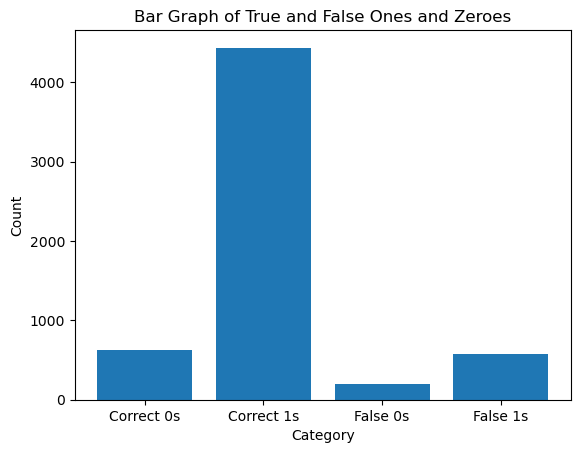

{'Accuracy': 0.8669064748201439,
 'Precision': 0.823239596820263,
 'Recall': 0.7380476449301274,
 'f1_macro': 0.7682547806469302,
 'auc-roc': 0.7380476449301274}

In [16]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, cutOff1, test_size = 0.2)

logr1 = LogisticRegression(C = logr_params1['C'], penalty = logr_params1['penalty'], solver = logr_params1['solver'])
logr1.fit(x_tr, y_tr)
predictions1 = logr1.predict(x_te)

analyze_binary(predictions1, y_te)

Text(0.5, 1.0, 'ROC curve')

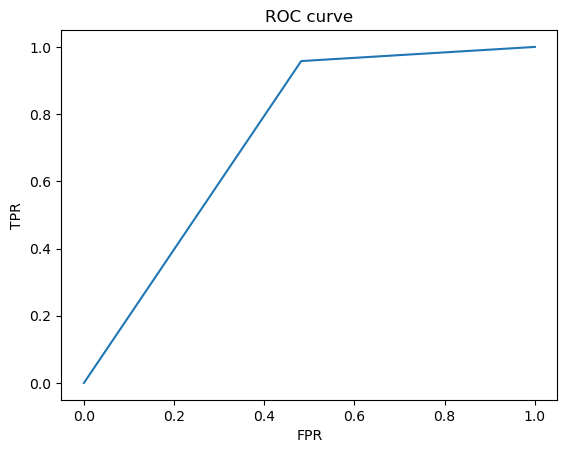

In [17]:
fpr1_logr, tpr1_logr, thresholds1_logr = metrics.roc_curve(y_te, predictions1)

plt.plot(fpr1_logr, tpr1_logr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

### Cutoff = 2

In [19]:
logr_param_grid_C2 = {
    'C': [1.0, 2.0, 3.0, 4.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

logr_grid_search2 = GridSearchCV(regressor, param_grid=logr_param_grid_C2, cv=kf)
logr_grid_search2.fit(x_train, cutOff2)

print("Best Hyperparameters:", logr_grid_search2.best_params_)
print("Best Score:", logr_grid_search2.best_score_)

bestparam2 = logr_grid_search2.best_params_

Best Hyperparameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8071877474402671


Accuracy: 0.8003
f1_macro: 0.789410
Precision: 0.7988
Recall: 0.7846
true_negatives: 1673.0000
auc_roc: 0.7846
Confusion Matrix:
[[1673  730]
 [ 436 2999]]


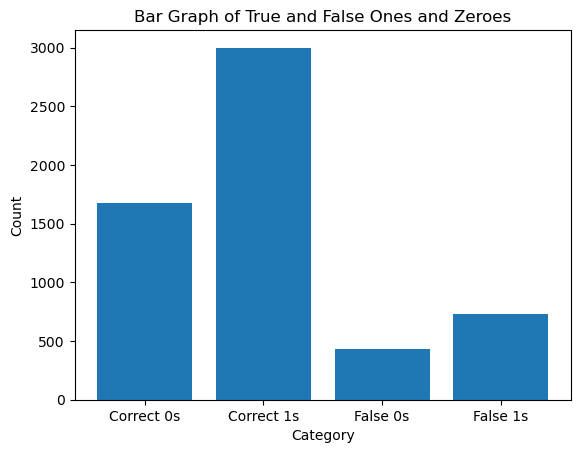

{'Accuracy': 0.8002740664611169,
 'Precision': 0.7987520060179585,
 'Recall': 0.7846421957996463,
 'f1_macro': 0.7894098892809198,
 'auc-roc': 0.7846421957996463}

In [20]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, cutOff2, test_size = 0.2)

logr2 = LogisticRegression(C = bestparam2['C'], penalty = bestparam2['penalty'], solver = bestparam2['solver'])
logr2.fit(x_tr, y_tr)
predictions2 = logr2.predict(x_te)

analyze_binary(predictions2, y_te)

Text(0.5, 1.0, 'ROC curve')

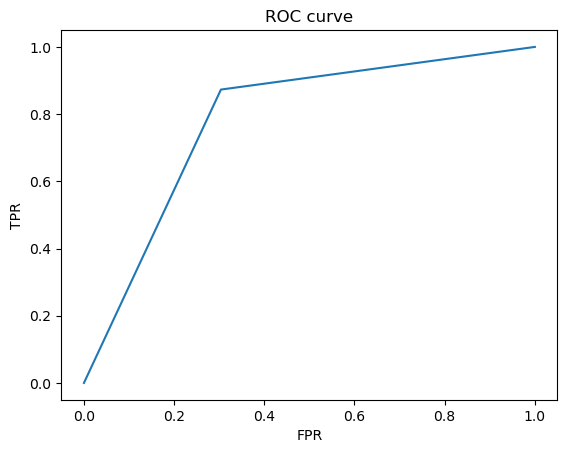

In [21]:
fpr2_logr, tpr2_logr, thresholds2_logr = metrics.roc_curve(y_te, predictions2)

plt.plot(fpr2_logr, tpr2_logr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

### Cutoff = 4


In [22]:
logr_param_grid_C3 = {
    'C': [1.0, 2.0, 3.0, 4.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

logr_grid_search3 = GridSearchCV(regressor, param_grid=logr_param_grid_C3, cv=kf)
logr_grid_search3.fit(x_train, cutOff3)

print("Best Hyperparameters:", logr_grid_search3.best_params_)
print("Best Score:", logr_grid_search3.best_score_)

bestparam3 = logr_grid_search3.best_params_

Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8169170657257693


Accuracy: 0.8253
f1_macro: 0.812649
Precision: 0.8182
Recall: 0.8085
true_negatives: 3167.0000
auc_roc: 0.8085
Confusion Matrix:
[[3167  429]
 [ 591 1651]]


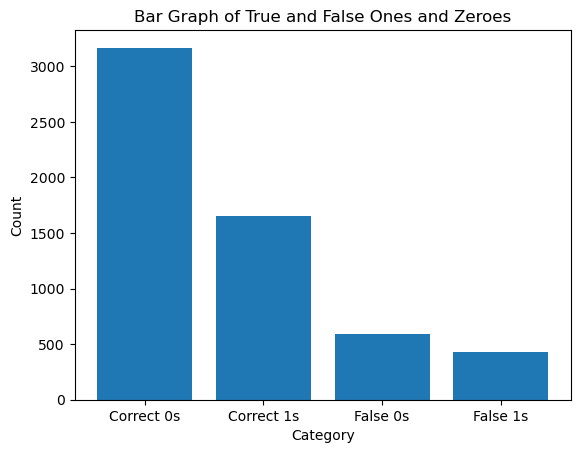

{'Accuracy': 0.8252826310380267,
 'Precision': 0.8182427488025545,
 'Recall': 0.8085484267880161,
 'f1_macro': 0.8126490609045033,
 'auc-roc': 0.808548426788016}

In [23]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, cutOff3, test_size = 0.2)

logr3 = LogisticRegression(C = bestparam3['C'], penalty = bestparam3['penalty'], solver = bestparam3['solver'])

logr3.fit(x_tr, y_tr)
predictions3 = logr3.predict(x_te)

analyze_binary(predictions3, y_te)

Text(0.5, 1.0, 'ROC curve')

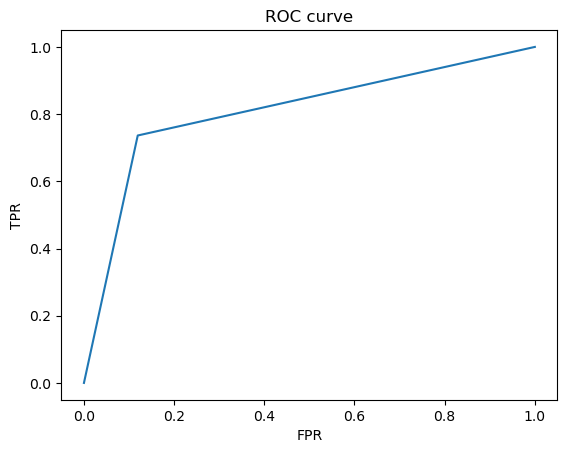

In [24]:
fpr3_logr, tpr3_logr, thresholds3_logr = metrics.roc_curve(y_te, predictions3)

plt.plot(fpr3_logr, tpr3_logr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

### Cutoff = 4

In [30]:
logr_param_grid_C4 = {
    'C': [1.0, 2.0, 3.0, 4.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

logr_grid_search4 = GridSearchCV(regressor, param_grid=logr_param_grid_C4, cv=kf)
logr_grid_search4.fit(x_train, cutOff4)

print("Best Hyperparameters:", logr_grid_search4.best_params_)
print("Best Score:", logr_grid_search4.best_score_)

logrparam4 = logr_grid_search4.best_params_

Best Hyperparameters: {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8541574308041758


Accuracy: 0.8476
f1_macro: 0.713416
Precision: 0.7742
Recall: 0.6851
true_negatives: 4471.0000
auc_roc: 0.6851
Confusion Matrix:
[[4471  227]
 [ 663  477]]


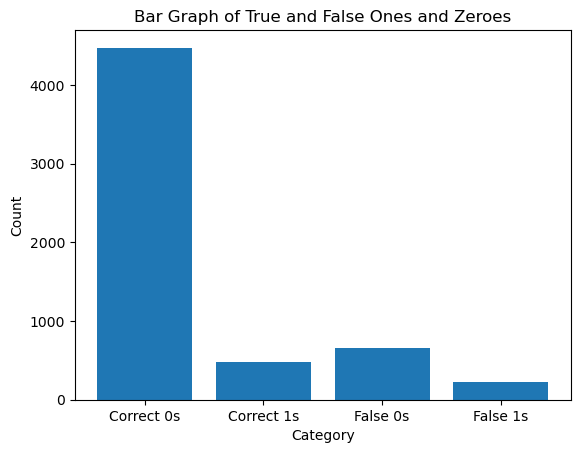

{'Accuracy': 0.8475505310037684,
 'Precision': 0.7742088726670681,
 'Recall': 0.6850513096278371,
 'f1_macro': 0.7134164152998135,
 'auc-roc': 0.6850513096278371}

In [31]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, cutOff4, test_size = 0.2)

logr4 = LogisticRegression(C = logrparam4['C'], penalty = logrparam4['penalty'], solver = logrparam4['solver'])
logr4.fit(x_tr, y_tr)
predictions4 = logr4.predict(x_te)

analyze_binary(predictions4, y_te)

Text(0.5, 1.0, 'ROC curve')

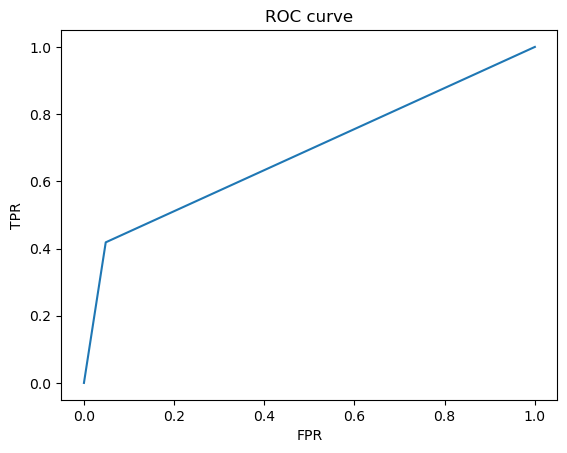

In [32]:
fpr4_logr, tpr4_logr, thresholds4_logr = metrics.roc_curve(y_te, predictions4)

plt.plot(fpr4_logr, tpr4_logr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

## Passive Aggressive Binary Classifier

In [33]:
from sklearn.linear_model import PassiveAggressiveClassifier

PA_classifier = PassiveAggressiveClassifier()

In [34]:
PA_param_grid1 = {
    'C': [0.05, 0.1, 0.5,],
    'max_iter': [100, 500, 1000],
    'loss': ['hinge', 'squared_hinge']
}

PA_grid_search1 = GridSearchCV(PA_classifier, param_grid=PA_param_grid1, cv=kf)
PA_grid_search1.fit(x_train, cutOff1)

print("Best Hyperparameters:", PA_grid_search1.best_params_)
print("Best Score:", PA_grid_search1.best_score_)

PA_param1 = PA_grid_search1.best_params_

Best Hyperparameters: {'C': 0.05, 'loss': 'hinge', 'max_iter': 100}
Best Score: 0.8623795009368065


Accuracy: 0.8585
f1_macro: 0.764890
Precision: 0.7899
Recall: 0.7470
true_negatives: 664.0000
auc_roc: 0.7470
Confusion Matrix:
[[ 664  524]
 [ 302 4348]]


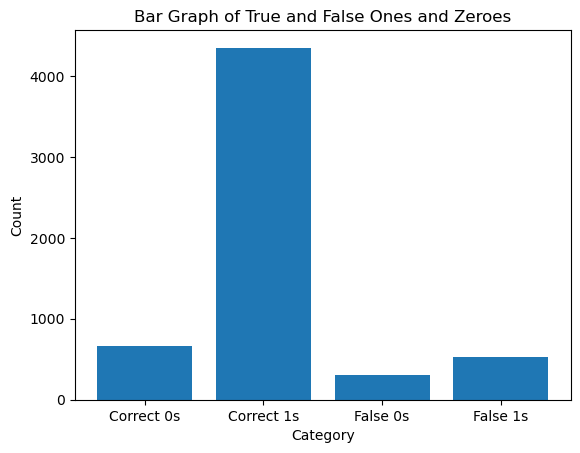

{'Accuracy': 0.8585131894484412,
 'Precision': 0.7899086171200114,
 'Recall': 0.7469881611817095,
 'f1_macro': 0.764890454534551,
 'auc-roc': 0.7469881611817096}

In [35]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, cutOff1, test_size = 0.2)

PA1 = PassiveAggressiveClassifier(C = PA_param1['C'], max_iter = PA_param1['max_iter'], loss = PA_param1['loss'])

PA1.fit(x_tr, y_tr)
PA_predictions1 = PA1.predict(x_te)

analyze_binary(PA_predictions1, y_te)


Text(0.5, 1.0, 'ROC curve')

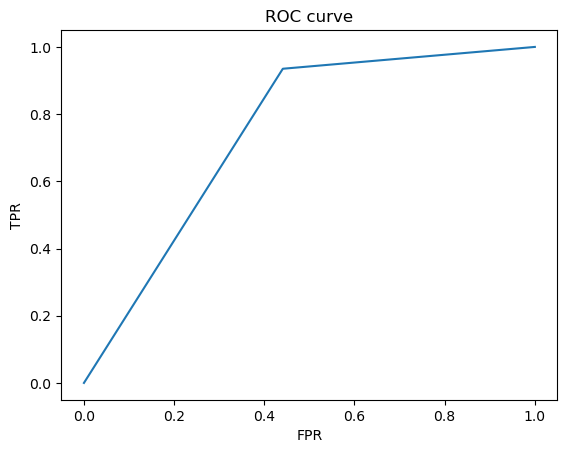

In [36]:
fpr1_PA, tpr1_PA, thresholds1_PA = metrics.roc_curve(y_te, PA_predictions1)

plt.plot(fpr1_PA, tpr1_PA)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

### Cutoff = 2

In [37]:
PA_param_grid2 = {
    'C': [0.05, 0.1, 0.5],
    'max_iter': [300, 500, 1000],
    'loss': ['hinge', 'squared_hinge']
}

PA_grid_search2 = GridSearchCV(PA_classifier, param_grid=PA_param_grid2, cv=kf)
PA_grid_search2.fit(x_train, cutOff2)

print("Best Hyperparameters:", PA_grid_search2.best_params_)
print("Best Score:", PA_grid_search2.best_score_)

PA_param2 = PA_grid_search2.best_params_

Best Hyperparameters: {'C': 0.05, 'loss': 'hinge', 'max_iter': 300}
Best Score: 0.7955394533097182


Accuracy: 0.7938
f1_macro: 0.783789
Precision: 0.7853
Recall: 0.7825
true_negatives: 1690.0000
auc_roc: 0.7825
Confusion Matrix:
[[1690  635]
 [ 569 2944]]


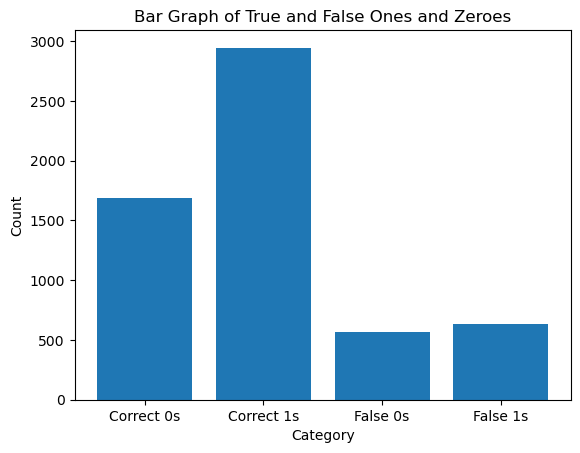

{'Accuracy': 0.7937649880095923,
 'Precision': 0.7853473875755245,
 'Recall': 0.7824559470354353,
 'f1_macro': 0.7837892707069096,
 'auc-roc': 0.7824559470354352}

In [38]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, cutOff2, test_size = 0.2)

PA2 = PassiveAggressiveClassifier(C = PA_param2['C'], max_iter = PA_param2['max_iter'], loss = PA_param2['loss'])

PA2.fit(x_tr, y_tr)
PA_predictions2 = PA2.predict(x_te)

analyze_binary(PA_predictions2, y_te)

Text(0.5, 1.0, 'ROC curve')

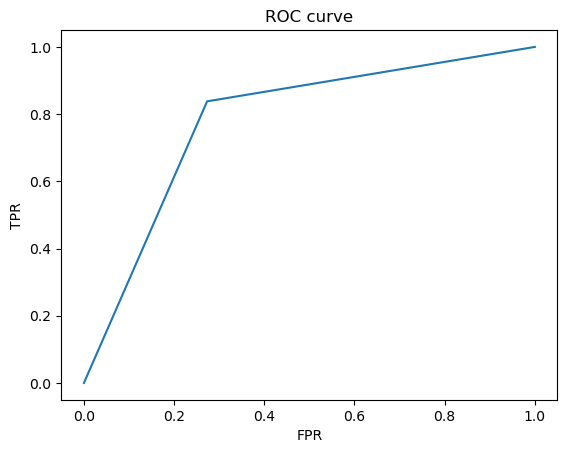

In [39]:
fpr2_PA, tpr2_PA, thresholds2_PA = metrics.roc_curve(y_te, PA_predictions2)

plt.plot(fpr2_PA, tpr2_PA)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

### Cutoff = 3

In [40]:
PA_param_grid3 = {
    'C': [0.1, 1.0, 10.0],
    'max_iter': [300, 500, 1000],
    'loss': ['hinge', 'squared_hinge']
}

PA_grid_search3 = GridSearchCV(PA_classifier, param_grid=PA_param_grid3, cv=kf)
PA_grid_search3.fit(x_train, cutOff3)

print("Best Hyperparameters:", PA_grid_search3.best_params_)
print("Best Score:", PA_grid_search3.best_score_)

PA_param3 = PA_grid_search3.best_params_

Best Hyperparameters: {'C': 0.1, 'loss': 'hinge', 'max_iter': 500}
Best Score: 0.7999243582201714


Accuracy: 0.7922
f1_macro: 0.779945
Precision: 0.7808
Recall: 0.7792
true_negatives: 3002.0000
auc_roc: 0.7792
Confusion Matrix:
[[3002  590]
 [ 623 1623]]


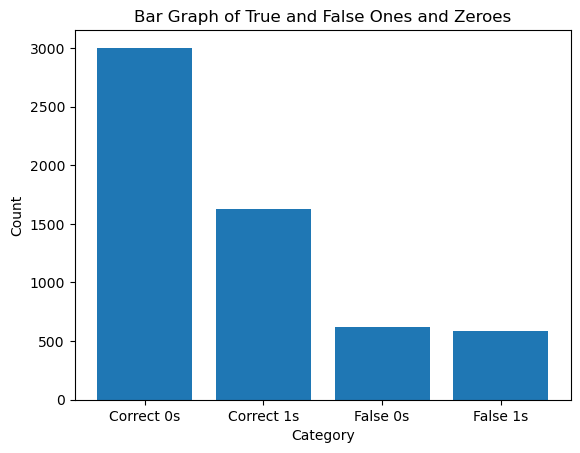

{'Accuracy': 0.7922233641658102,
 'Precision': 0.7807657572027362,
 'Recall': 0.7791820449916407,
 'f1_macro': 0.7799452670293344,
 'auc-roc': 0.7791820449916407}

In [41]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, cutOff3, test_size = 0.2)

PA3 = PassiveAggressiveClassifier(C = PA_param3['C'], max_iter = PA_param3['max_iter'], loss = PA_param3['loss'])

PA3.fit(x_tr, y_tr)
PA_predictions3 = PA3.predict(x_te)

analyze_binary(PA_predictions3, y_te)

Text(0.5, 1.0, 'ROC curve')

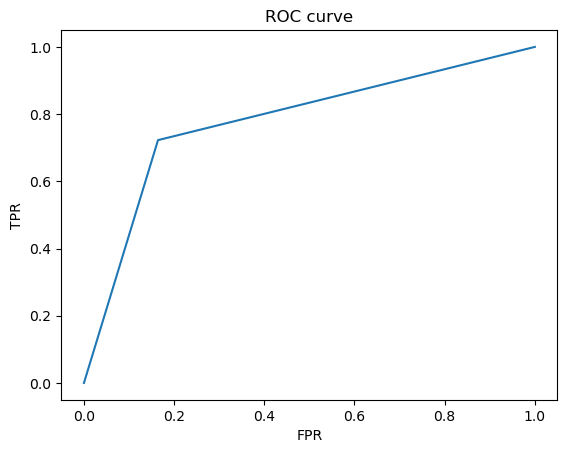

In [42]:
fpr3_PA, tpr3_PA, thresholds3_PA = metrics.roc_curve(y_te, PA_predictions3)

plt.plot(fpr3_PA, tpr3_PA)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

### Cutoff = 4

In [43]:
PA_param_grid4 = {
    'C': [0.1, 1.0, 10.0],
    'max_iter': [300, 500, 1000],
    'loss': ['hinge', 'squared_hinge']
}

PA_grid_search4 = GridSearchCV(PA_classifier, param_grid=PA_param_grid4, cv=kf)
PA_grid_search4.fit(x_train, cutOff4)

print("Best Hyperparameters:", PA_grid_search4.best_params_)
print("Best Score:", PA_grid_search4.best_score_)

PA_param4 = PA_grid_search4.best_params_

Best Hyperparameters: {'C': 0.1, 'loss': 'hinge', 'max_iter': 1000}
Best Score: 0.8372676977730574


Accuracy: 0.8321
f1_macro: 0.720655
Precision: 0.7347
Recall: 0.7097
true_negatives: 4273.0000
auc_roc: 0.7097
Confusion Matrix:
[[4273  412]
 [ 568  585]]


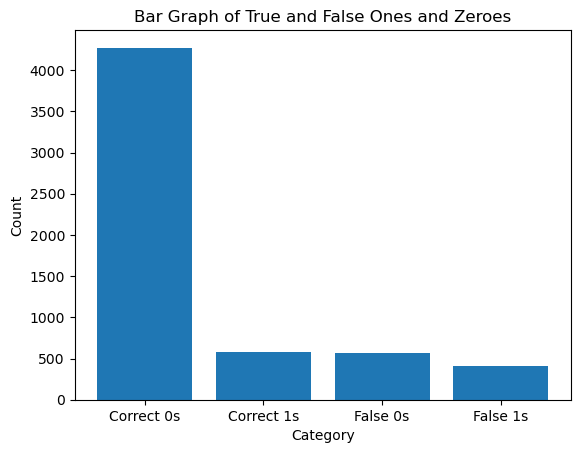

{'Accuracy': 0.8321342925659473,
 'Precision': 0.7347145754553477,
 'Recall': 0.7097159190307685,
 'f1_macro': 0.7206548540347348,
 'auc-roc': 0.7097159190307685}

In [44]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, cutOff4, test_size = 0.2)

PA4 = PassiveAggressiveClassifier(C = PA_param4['C'], max_iter = PA_param4['max_iter'], loss = PA_param4['loss'])

PA4.fit(x_tr, y_tr)
PA_predictions4 = PA4.predict(x_te)

analyze_binary(PA_predictions4, y_te)

Text(0.5, 1.0, 'ROC curve')

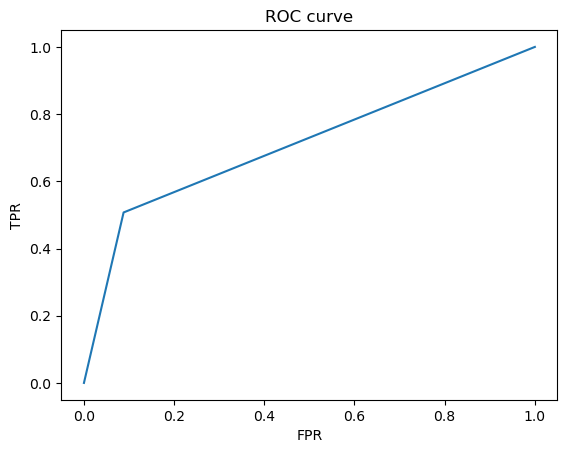

In [45]:
fpr4_PA, tpr4_PA, thresholds4_PA = metrics.roc_curve(y_te, PA_predictions4)

plt.plot(fpr4_PA, tpr4_PA)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

## K Nearest Neighbors Classifier

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats

KN_classifier = KNeighborsClassifier()

### Cutoff = 1

In [47]:
KN_param_grid1 = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

KN_grid_search1 = GridSearchCV(KN_classifier, param_grid=KN_param_grid1, cv=kf)
KN_grid_search1.fit(x_train, cutOff1)

print("Best Hyperparameters:", KN_grid_search1.best_params_)
print("Best Score:", KN_grid_search1.best_score_)

KN_param1 = KN_grid_search1.best_params_

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using bru

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using bru

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically p

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using bru

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Best Score: 0.7378489797310197


Accuracy: 0.8135
f1_macro: 0.558900
Precision: 0.7594
Recall: 0.5594
true_negatives: 157.0000
auc_roc: 0.5594
Confusion Matrix:
[[ 157 1022]
 [  67 4592]]


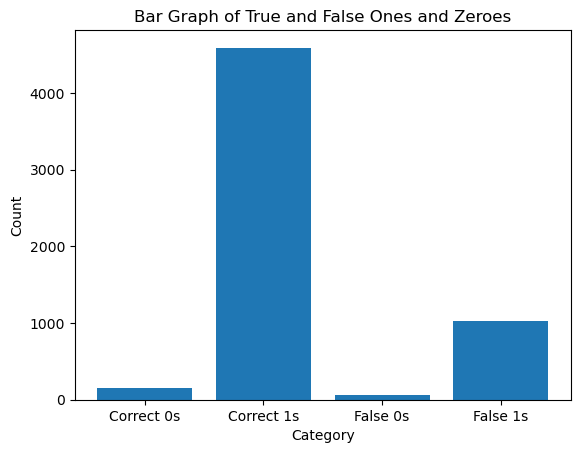

{'Accuracy': 0.8134635149023638,
 'Precision': 0.7594239846811542,
 'Recall': 0.5593914648219785,
 'f1_macro': 0.5589000472420109,
 'auc-roc': 0.5593914648219785}

In [48]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, cutOff1, test_size = 0.2)

KN1 = KNeighborsClassifier(algorithm = KN_param1['algorithm'], n_neighbors = KN_param1['n_neighbors'], weights = KN_param1['weights'])

KN1.fit(x_tr, y_tr)
KN_predictions1 = KN1.predict(x_te)

analyze_binary(KN_predictions1, y_te)

Text(0.5, 1.0, 'ROC curve')

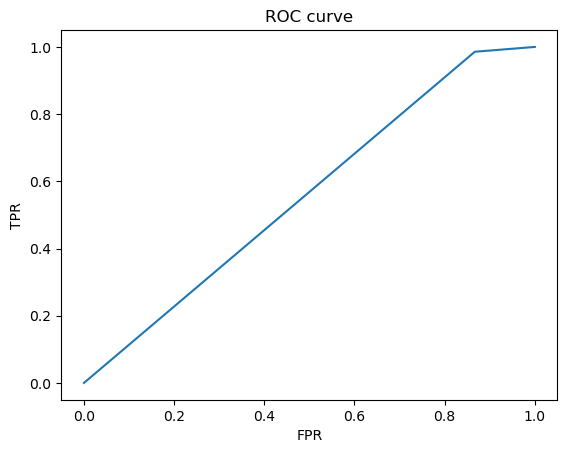

In [49]:
fpr1_KN, tpr1_KN, thresholds1_KN = metrics.roc_curve(y_te, KN_predictions1)

plt.plot(fpr1_KN, tpr1_KN)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

### Cutoff = 2

In [50]:
KN_param_grid2 = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

KN_grid_search2 = GridSearchCV(KN_classifier, param_grid=KN_param_grid2, cv=kf)
KN_grid_search2.fit(x_train, cutOff2)

print("Best Hyperparameters:", KN_grid_search2.best_params_)
print("Best Score:", KN_grid_search2.best_score_)

KN_param2 = KN_grid_search2.best_params_

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using bru

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using bru

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically p

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using bru

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Best Score: 0.6069758706361228


Accuracy: 0.5462
f1_macro: 0.531700
Precision: 0.6330
Recall: 0.5982
true_negatives: 2109.0000
auc_roc: 0.5982
Confusion Matrix:
[[2109  278]
 [2371 1080]]


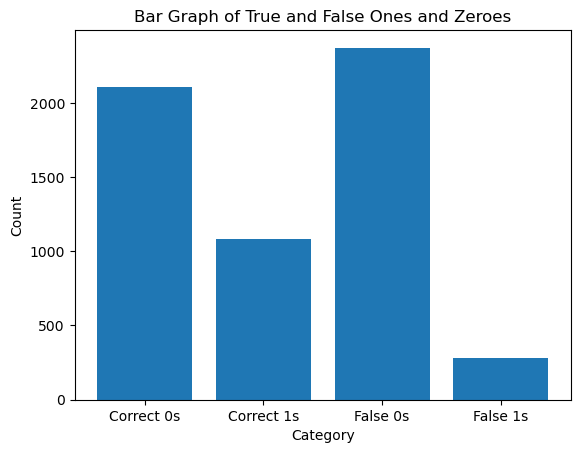

{'Accuracy': 0.5462487153134635,
 'Precision': 0.6330230578055964,
 'Recall': 0.5982442931667561,
 'f1_macro': 0.5316999280782784,
 'auc-roc': 0.5982442931667561}

In [51]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, cutOff2, test_size = 0.2)

KN2 = KNeighborsClassifier(algorithm = KN_param2['algorithm'], n_neighbors = KN_param2['n_neighbors'], weights = KN_param2['weights'])

KN2.fit(x_tr, y_tr)
KN_predictions2 = KN2.predict(x_te)

analyze_binary(KN_predictions2, y_te)

Text(0.5, 1.0, 'ROC curve')

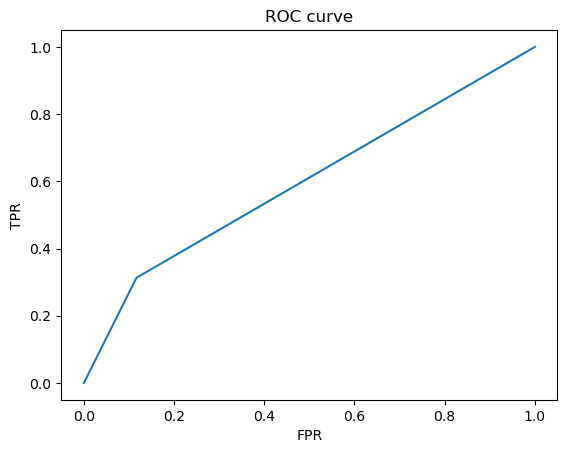

In [52]:
fpr2_KN, tpr2_KN, thresholds2_KN = metrics.roc_curve(y_te, KN_predictions2)

plt.plot(fpr2_KN, tpr2_KN)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

### Cutoff = 3

In [53]:
KN_param_grid3 = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

KN_grid_search3 = GridSearchCV(KN_classifier, param_grid=KN_param_grid3, cv=kf)
KN_grid_search3.fit(x_train, cutOff3)

print("Best Hyperparameters:", KN_grid_search3.best_params_)
print("Best Score:", KN_grid_search3.best_score_)

KN_param3 = KN_grid_search3.best_params_

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using bru

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using bru

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically p

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using bru

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}
Best Score: 0.6402751921666857


/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Accuracy: 0.6228
f1_macro: 0.587509
Precision: 0.5976
Recall: 0.5874
true_negatives: 2672.0000
auc_roc: 0.5874
Confusion Matrix:
[[2672  852]
 [1350  964]]


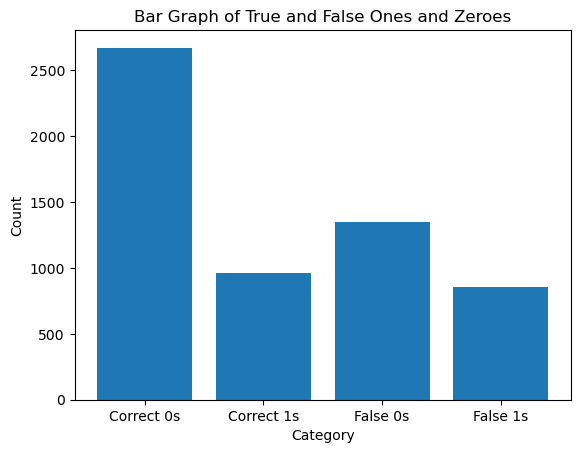

{'Accuracy': 0.6228160328879754,
 'Precision': 0.5975915504373523,
 'Recall': 0.5874119631086305,
 'f1_macro': 0.5875089282906647,
 'auc-roc': 0.5874119631086305}

In [54]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, cutOff3, test_size = 0.2)

KN3 = KNeighborsClassifier(algorithm = KN_param3['algorithm'], n_neighbors = KN_param3['n_neighbors'], weights = KN_param3['weights'])

KN3.fit(x_tr, y_tr)
KN_predictions3 = KN3.predict(x_te)

analyze_binary(KN_predictions3, y_te)

Text(0.5, 1.0, 'ROC curve')

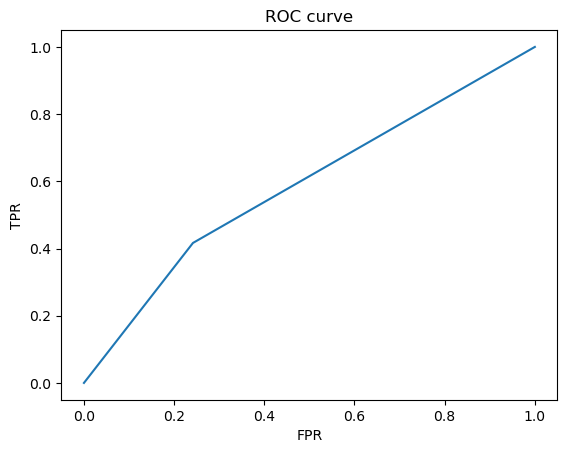

In [55]:
fpr3_KN, tpr3_KN, thresholds3_KN = metrics.roc_curve(y_te, KN_predictions3)

plt.plot(fpr3_KN, tpr3_KN)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

### Cutoff = 4

In [56]:
KN_param_grid4 = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

KN_grid_search4 = GridSearchCV(KN_classifier, param_grid=KN_param_grid4, cv=kf)
KN_grid_search4.fit(x_train, cutOff4)

print("Best Hyperparameters:", KN_grid_search4.best_params_)
print("Best Score:", KN_grid_search4.best_score_)

KN_param4 = KN_grid_search4.best_params_

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using bru

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using bru

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically p

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using bru

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}
Best Score: 0.7975263999378339


Accuracy: 0.8133
f1_macro: 0.575852
Precision: 0.7133
Recall: 0.5689
true_negatives: 4558.0000
auc_roc: 0.5689
Confusion Matrix:
[[4558  126]
 [ 964  190]]


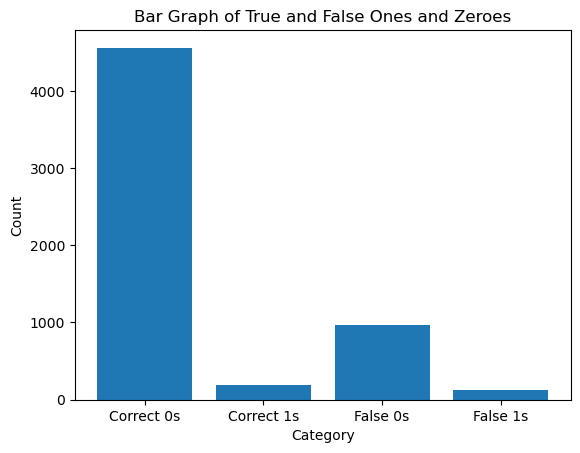

{'Accuracy': 0.8132922233641658,
 'Precision': 0.7133456966151505,
 'Recall': 0.5688723143205159,
 'f1_macro': 0.575851739872904,
 'auc-roc': 0.5688723143205159}

In [57]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, cutOff4, test_size = 0.2)

KN4 = KNeighborsClassifier(algorithm = KN_param4['algorithm'], n_neighbors = KN_param4['n_neighbors'], weights = KN_param4['weights'])

KN4.fit(x_tr, y_tr)
KN_predictions4 = KN4.predict(x_te)

analyze_binary(KN_predictions4, y_te)

Text(0.5, 1.0, 'ROC curve')

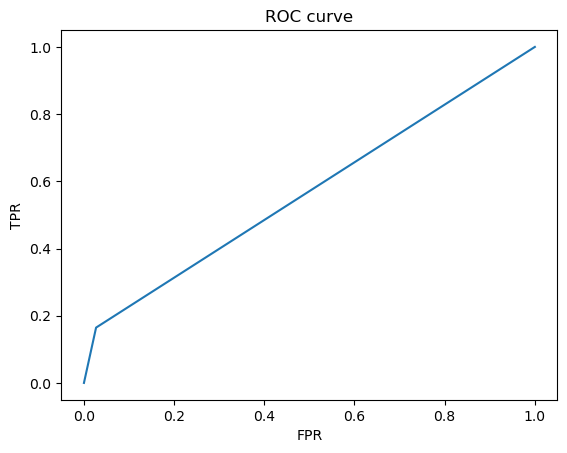

In [58]:
fpr4_KN, tpr4_KN, thresholds4_KN = metrics.roc_curve(y_te, KN_predictions4)

plt.plot(fpr4_KN, tpr4_KN)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

## Naive Bayes Approach


In [59]:
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()

### Cutoff = 1

In [60]:
NB_param_grid1 = {
    'alpha': [9.6, 9.7, 9.8],
    'fit_prior': [True, False]
}

NB_grid_search1 = GridSearchCV(NB_classifier, NB_param_grid1, cv = kf)
NB_grid_search1.fit(x_train, cutOff1)

print("Best Hyperparameters:", NB_grid_search1.best_params_)
print("Best Score:", NB_grid_search1.best_score_)

NB_param1 = NB_grid_search1.best_params_

Best Hyperparameters: {'alpha': 9.7, 'fit_prior': False}
Best Score: 0.8556989959563225


Accuracy: 0.8556
f1_macro: 0.744573
Precision: 0.7956
Recall: 0.7169
true_negatives: 573.0000
auc_roc: 0.7169
Confusion Matrix:
[[ 573  612]
 [ 231 4422]]


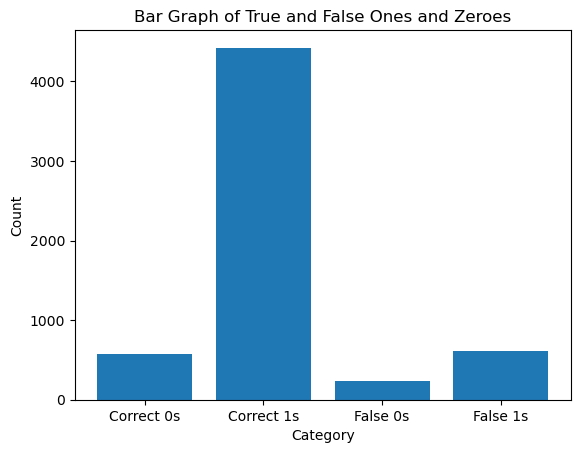

{'Accuracy': 0.855601233299075,
 'Precision': 0.7955566328073578,
 'Recall': 0.7169494568632733,
 'f1_macro': 0.7445725413590167,
 'auc-roc': 0.7169494568632733}

In [61]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, cutOff1, test_size = 0.2)

NB1 = MultinomialNB(alpha = NB_param1['alpha'], fit_prior = NB_param1['fit_prior'])
NB1.fit(x_tr, y_tr)

NB_predictions1 = NB1.predict(x_te)

analyze_binary(NB_predictions1, y_te)

Text(0.5, 1.0, 'ROC curve')

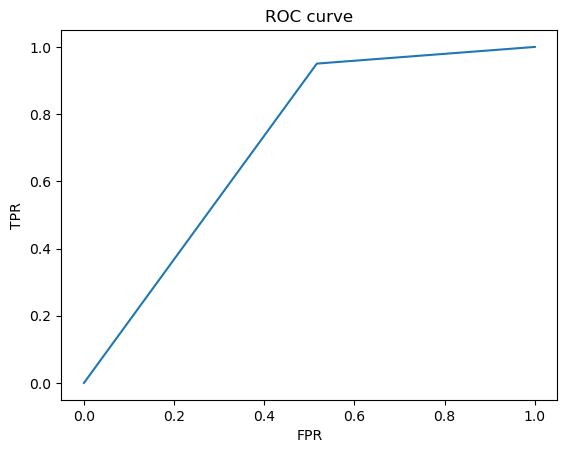

In [62]:
fpr1_NB, tpr1_NB, thresholds1_NB = metrics.roc_curve(y_te, NB_predictions1)

plt.plot(fpr1_NB, tpr1_NB)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

### Cutoff = 2

In [63]:
NB_param_grid2 = {
    'alpha': [6.5, 7.0, 7.5],
    'fit_prior': [True, False]
}

NB_grid_search2 = GridSearchCV(NB_classifier, NB_param_grid2, cv = kf)
NB_grid_search2.fit(x_train, cutOff2)

print("Best Hyperparameters:", NB_grid_search2.best_params_)
print("Best Score:", NB_grid_search2.best_score_)

NB_param2 = NB_grid_search2.best_params_

Best Hyperparameters: {'alpha': 7.0, 'fit_prior': False}
Best Score: 0.8033849637781637


Accuracy: 0.8027
f1_macro: 0.794878
Precision: 0.7959
Recall: 0.7940
true_negatives: 1774.0000
auc_roc: 0.7940
Confusion Matrix:
[[1774  599]
 [ 553 2912]]


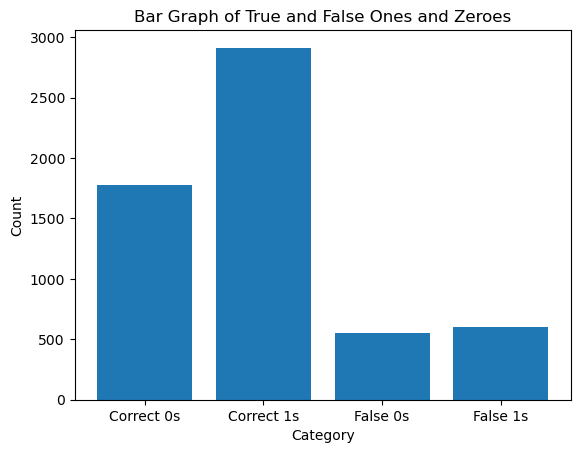

{'Accuracy': 0.802672147995889,
 'Precision': 0.7958741493522048,
 'Recall': 0.7939904736364913,
 'f1_macro': 0.7948780011711888,
 'auc-roc': 0.7939904736364914}

In [64]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, cutOff2, test_size = 0.2)

NB2 = MultinomialNB(alpha = NB_param2['alpha'], fit_prior = NB_param2['fit_prior'])
NB2.fit(x_tr, y_tr)

NB_predictions2 = NB2.predict(x_te)

analyze_binary(NB_predictions2, y_te)

Text(0.5, 1.0, 'ROC curve')

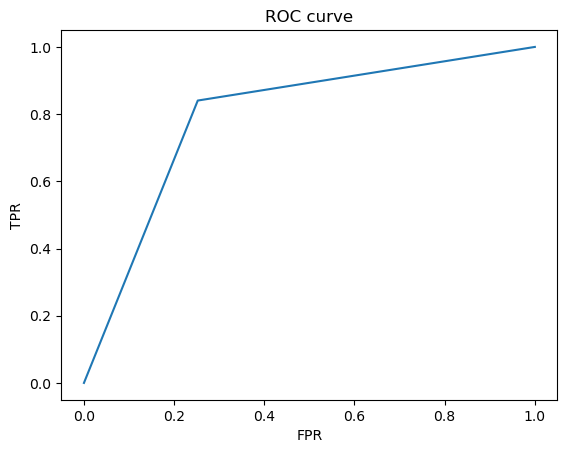

In [65]:
fpr2_NB, tpr2_NB, thresholds2_NB = metrics.roc_curve(y_te, NB_predictions2)

plt.plot(fpr2_NB, tpr2_NB)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

### Cutoff = 3


In [66]:
NB_param_grid3 = {
    'alpha': [6, 6.5, 7.0, 7.5],
    'fit_prior': [True, False]
}

NB_grid_search3 = GridSearchCV(NB_classifier, NB_param_grid3, cv = kf)
NB_grid_search3.fit(x_train, cutOff3)

print("Best Hyperparameters:", NB_grid_search3.best_params_)
print("Best Score:", NB_grid_search3.best_score_)

NB_param3 = NB_grid_search3.best_params_

Best Hyperparameters: {'alpha': 6.5, 'fit_prior': False}
Best Score: 0.8072559529898781


Accuracy: 0.8004
f1_macro: 0.789848
Precision: 0.7897
Recall: 0.7900
true_negatives: 2992.0000
auc_roc: 0.7900
Confusion Matrix:
[[2992  586]
 [ 579 1681]]


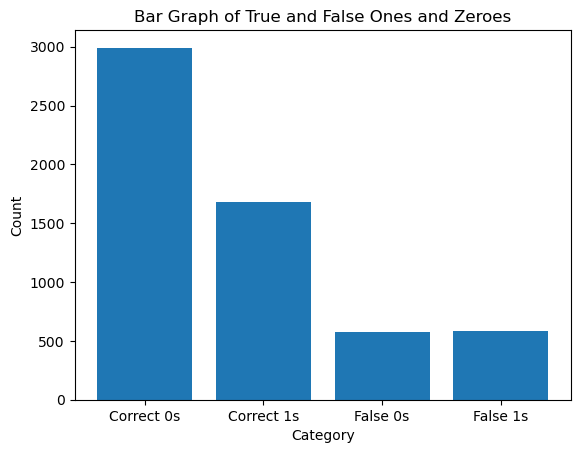

{'Accuracy': 0.8004453579993148,
 'Precision': 0.789684572470708,
 'Recall': 0.7900133312227625,
 'f1_macro': 0.7898476627529085,
 'auc-roc': 0.7900133312227625}

In [67]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, cutOff3, test_size = 0.2)

NB3 = MultinomialNB(alpha = NB_param3['alpha'], fit_prior = NB_param3['fit_prior'])
NB3.fit(x_tr, y_tr)

NB_predictions3 = NB3.predict(x_te)

analyze_binary(NB_predictions3, y_te)

Text(0.5, 1.0, 'ROC curve')

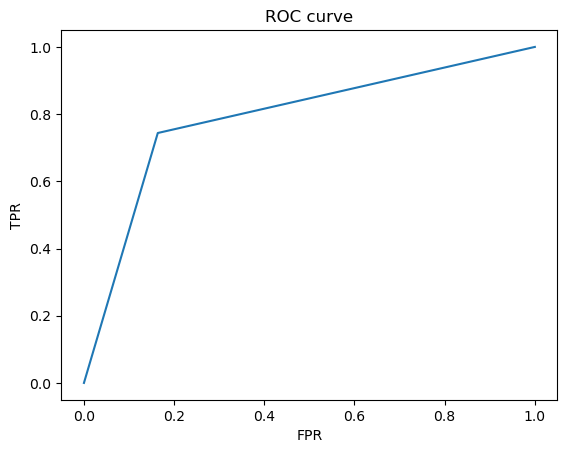

In [68]:
fpr3_NB, tpr3_NB, thresholds3_NB = metrics.roc_curve(y_te, NB_predictions3)

plt.plot(fpr3_NB, tpr3_NB)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

### Cutoff = 4

In [70]:
NB_param_grid4 = {
    'alpha': [8.8, 9, 10],
    'fit_prior': [True, False]
}

NB_grid_search4 = GridSearchCV(NB_classifier, NB_param_grid4, cv = kf)
NB_grid_search4.fit(x_train, cutOff4)

print("Best Hyperparameters:", NB_grid_search4.best_params_)
print("Best Score:", NB_grid_search4.best_score_)

NB_param4 = NB_grid_search4.best_params_

Best Hyperparameters: {'alpha': 9, 'fit_prior': False}
Best Score: 0.832710902669724


Accuracy: 0.8371
f1_macro: 0.693369
Precision: 0.7341
Recall: 0.6716
true_negatives: 4442.0000
auc_roc: 0.6716
Confusion Matrix:
[[4442  302]
 [ 649  445]]


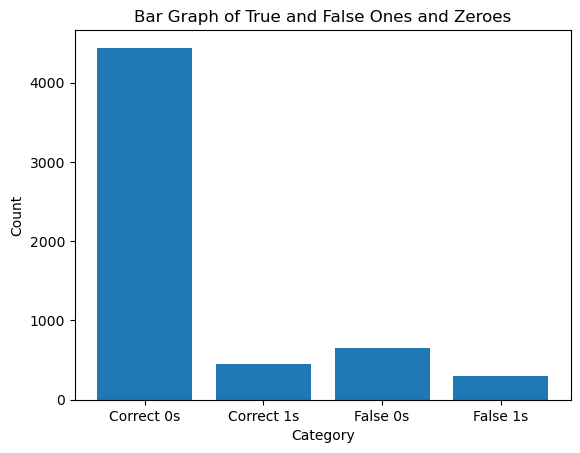

{'Accuracy': 0.8371017471736896,
 'Precision': 0.73411816584744,
 'Recall': 0.6715524044997857,
 'f1_macro': 0.6933687207749155,
 'auc-roc': 0.6715524044997857}

In [71]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, cutOff4, test_size = 0.2)

NB4 = MultinomialNB(alpha = NB_param4['alpha'], fit_prior = NB_param4['fit_prior'])
NB4.fit(x_tr, y_tr)

NB_predictions4 = NB4.predict(x_te)

analyze_binary(NB_predictions4, y_te)

Text(0.5, 1.0, 'ROC curve')

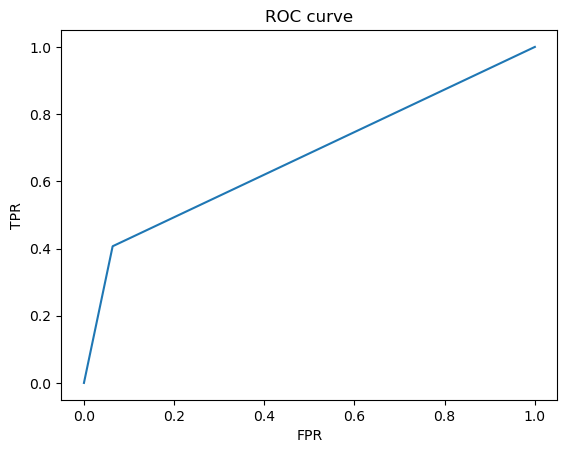

In [72]:
fpr4_NB, tpr4_NB, thresholds4_NB = metrics.roc_curve(y_te, NB_predictions4)

plt.plot(fpr4_NB, tpr4_NB)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

# Multiclass Classifier


## Logistic Regression Model

#### Function to plot results:


In [79]:
from sklearn.metrics import accuracy_score


def analyze_multiclass(y_pred, y_actual):
    accuracy = accuracy_score(y_actual, y_pred)

    # Calculate macro F1 score
    f1_macro = f1_score(y_actual, y_pred, average='macro')
    
    precision = precision_score(y_actual, y_pred, average='macro')
    recall = recall_score(y_actual, y_pred, average='macro')
    
    
    #confusion matrix
    cm = confusion_matrix(y_actual, y_pred)
    
    # Generate histogram of correct and incorrect predictions for each star rating
    labels = np.unique(y_actual)
    correct_counts = np.zeros(len(labels))
    incorrect_counts = np.zeros(len(labels))
    
    for label in labels:
        correct_counts[label-1] = np.sum((y_pred == y_actual) & (y_actual == label))
        incorrect_counts[label-1] = np.sum((y_pred != y_actual) & (y_actual == label))

    x = np.arange(len(labels))
    width = 0.35
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, correct_counts, width, label='Correct')
    rects2 = ax.bar(x + width/2, incorrect_counts, width, label='Incorrect')

    ax.set_ylabel('Count')
    ax.set_xlabel('Star Rating')
    ax.set_title('Correct and Incorrect Predictions by Star Rating')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()
    
    print('Accuracy: {:.4f}'.format(accuracy))
    print('f1_macro: {:4f}'.format(f1_macro))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('Confusion Matrix:')
    print(cm)

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'f1_macro': f1_macro,
    }

In [80]:
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.preprocessing import label_binarize


def roc_score(model, x, y):
    scoring = ['accuracy', 'f1_macro', 'recall_macro', 'precision_macro', 'roc_auc_ovr']
    scores = cross_validate(model, x, y, cv=5, scoring=scoring)
    
    y_bin = label_binarize(y, classes=[0, 1, 2, 3, 4])
    
    pred_prob = cross_val_predict(model, x, y, cv=5, method='predict_proba')
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(5):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_bin[:, i], pred_prob[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_bin.ravel(), pred_prob.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    
    plt.figure()
    
    for i in range(5):
        plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
    
    plt.plot(fpr["micro"], tpr["micro"], label='Average ROC (Micro-average) (AUC = {:.2f})'.format(roc_auc["micro"]))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    return scores


In [81]:
classifier = LogisticRegression(max_iter = 20000)

y = y.astype(int)
y = np.ravel(y)

parameters_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 2.0, 3.0],
    'multi_class': ['auto', 'ovr', 'multinomial'],
}

classifier_logr = GridSearchCV(classifier, parameters_grid, cv=kf)

classifier_logr.fit(x_train, y)

print("Best Hyperparameters:", classifier_logr.best_params_)
print("Best Score:", classifier_logr.best_score_)

logr_paramsMC = classifier_logr.best_params_

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", 

Best Hyperparameters: {'C': 1.0, 'multi_class': 'ovr', 'penalty': 'l2'}
Best Score: 0.4933364921171558


/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


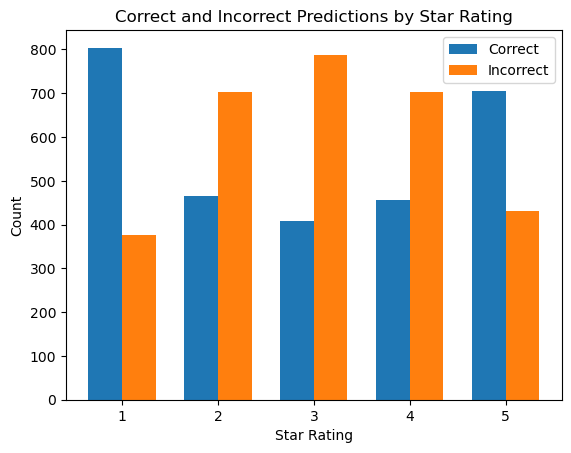

Accuracy: 0.4863
f1_macro: 0.481725
Precision: 0.4794
Recall: 0.4871
Confusion Matrix:
[[804 238  67  36  35]
 [274 465 241 110  77]
 [112 308 408 261 106]
 [ 47 107 190 456 359]
 [ 54  64  65 248 706]]
{'Accuracy': 0.48629667694415896, 'Precision': 0.47941465550303486, 'Recall': 0.4871222021536778, 'f1_macro': 0.4817252660267063}


In [82]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, y, test_size = 0.2)

classifierMC = LogisticRegression(C = logr_paramsMC['C'], penalty = logr_paramsMC['penalty'], multi_class = logr_paramsMC['multi_class'])
classifierMC.fit(x_tr, y_tr)

y_pred = classifierMC.predict(x_te)

print(analyze_multiclass(y_pred, y_te))

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

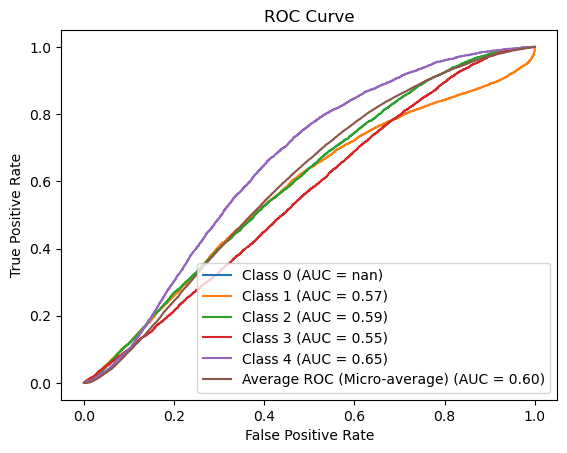

{'fit_time': array([1.26953673, 1.26226306, 1.40662909, 1.52765894, 1.85365701]),
 'score_time': array([0.01667404, 0.01680112, 0.01557994, 0.01689291, 0.01768899]),
 'test_accuracy': array([0.47207948, 0.45837616, 0.50668037, 0.49520384, 0.49563132]),
 'test_f1_macro': array([0.4625956 , 0.452673  , 0.50034926, 0.49191301, 0.48379927]),
 'test_recall_macro': array([0.47192022, 0.45942595, 0.50717972, 0.49522182, 0.49627959]),
 'test_precision_macro': array([0.46078916, 0.44920928, 0.49831094, 0.48964001, 0.48187529]),
 'test_roc_auc_ovr': array([0.79205902, 0.77720398, 0.81239372, 0.80701762, 0.80866285])}

In [83]:
roc_score(classifierMC, x_train, y)

#### Creating CSV for Kaggle:

In [84]:
y_kaggle = classifierMC.predict(x_test)

predictions_df = pd.DataFrame(y_kaggle, columns=['label'])
predictions_df.index.name = 'id'
predictions_df.to_csv('predictions.csv')

## Passive Aggressive Classifier

In [85]:
y = y.astype(int)
y = np.ravel(y)

PA_param_gridMC = {
    'C': [0.1, 1.0, 10.0],
    'fit_intercept': [True, False],
    'max_iter': [100, 1000, 10000],
    'tol': [1e-3, 1e-4, 1e-5]
}

PA_grid_searchMC = GridSearchCV(PA_classifier, PA_param_gridMC, cv=kf)
PA_grid_searchMC.fit(x_train, y)

print("Best Hyperparameters:", PA_grid_searchMC.best_params_)
print("Best Score:", PA_grid_searchMC.best_score_)

PA_paramMC = PA_grid_searchMC.best_params_

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/N

Best Hyperparameters: {'C': 0.1, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.001}
Best Score: 0.45928258983649856


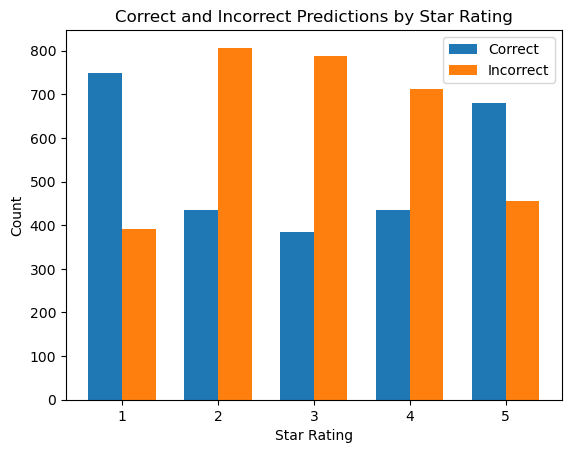

Accuracy: 0.4597
f1_macro: 0.455793
Precision: 0.4525
Recall: 0.4626
Confusion Matrix:
[[750 238  70  56  28]
 [331 436 245 148  83]
 [115 297 384 230 146]
 [ 74 103 199 434 336]
 [ 52  71  76 256 680]]
{'Accuracy': 0.45974648852346695, 'Precision': 0.4525302048078029, 'Recall': 0.4625958764589491, 'f1_macro': 0.4557926774043922}


In [86]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, y, test_size = 0.2)

PA_classifier = PassiveAggressiveClassifier(C = PA_paramMC['C'], fit_intercept = PA_paramMC['fit_intercept'], max_iter = PA_paramMC['max_iter'])
PA_classifier.fit(x_tr, y_tr)

y_pred = PA_classifier.predict(x_te)

print(analyze_multiclass(y_pred, y_te))

#### Reason for not plotting ROC curve for the above model:

The standard implementation of the Passive-Aggressive classifier in scikit-learn does not provide direct probability predictions. The Passive-Aggressive algorithm is primarily designed for online learning and handles updates to the model based on a loss function, rather than producing probability estimates.

## Naive Bayes Classifier


In [87]:
y = y.astype(int)
y = np.ravel(y)

# Define the parameter grid for Naive Bayes
NB_param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'fit_prior': [True, False]
}

# Perform grid search with cross-validation
NB_grid_search = GridSearchCV(NB_classifier, NB_param_grid, cv=kf)
NB_grid_search.fit(x_train, y)

# Print the best hyperparameters and score
print("Best Hyperparameters:", NB_grid_search.best_params_)
print("Best Score:", NB_grid_search.best_score_)

# Get the best parameters
NB_params = NB_grid_search.best_params_

Best Hyperparameters: {'alpha': 10.0, 'fit_prior': False}
Best Score: 0.4929595450881762


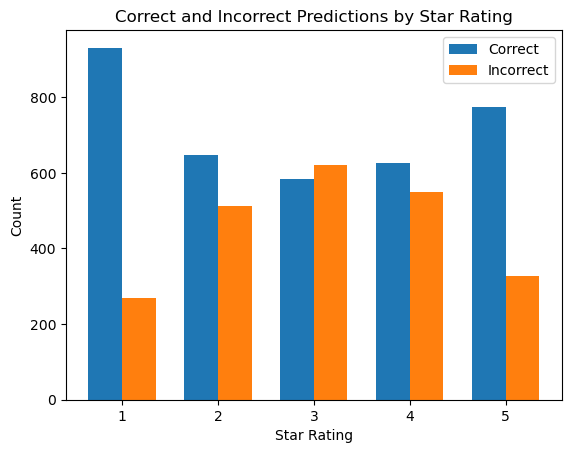

Accuracy: 0.6096
f1_macro: 0.606615
Precision: 0.6066
Recall: 0.6106
Confusion Matrix:
[[931 172  44  26  26]
 [216 647 146  95  55]
 [ 84 241 583 186 111]
 [ 40 102 143 625 265]
 [ 38  42  59 188 773]]
{'Accuracy': 0.6096265844467283, 'Precision': 0.6066090157187468, 'Recall': 0.6106359712027508, 'f1_macro': 0.6066154444128937}


In [88]:
x_tr, x_te, y_tr, y_te = train_test_split(x_train, y, test_size = 0.2)

NB_classifier = MultinomialNB(alpha = NB_params['alpha'], fit_prior = NB_params['fit_prior'])
NB_classifier.fit(x_tr, y_tr)

y_pred = classifierMC.predict(x_te)

print(analyze_multiclass(y_pred, y_te))

/Users/Nathan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


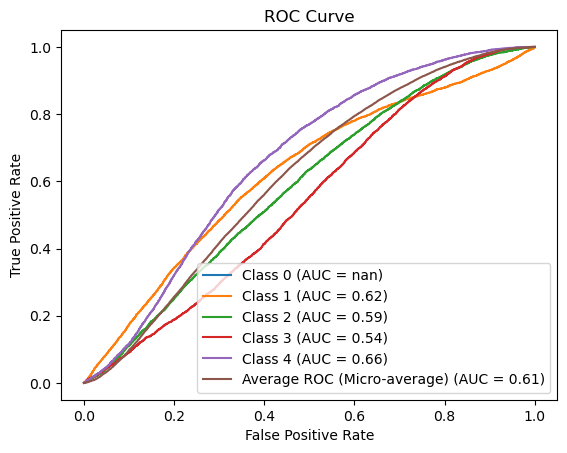

{'fit_time': array([0.01175904, 0.01157308, 0.01124883, 0.00929713, 0.00831008]),
 'score_time': array([0.01791596, 0.01870584, 0.01656032, 0.0153842 , 0.01525307]),
 'test_accuracy': array([0.47584789, 0.45700582, 0.50787941, 0.49691675, 0.50505397]),
 'test_f1_macro': array([0.46680676, 0.45493305, 0.50210856, 0.49513547, 0.49288253]),
 'test_recall_macro': array([0.47564675, 0.45814955, 0.50797006, 0.4966959 , 0.50561107]),
 'test_precision_macro': array([0.46518002, 0.45606656, 0.50223111, 0.49489733, 0.49043344]),
 'test_roc_auc_ovr': array([0.79161216, 0.77785458, 0.80594541, 0.80404663, 0.81051208])}

In [89]:
roc_score(NB_classifier, x_train, y)

# K Means Clustering

#### Vectorizing new data for K-Means Clustering

To cluster by category, it makes more sense to use the "style" column in the training and test data because it has information that is most relevant to the category of the review (eg. keywords that classify the review within it's category).

In [90]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

k = 6
kmeans = KMeans(n_clusters=k, algorithm='elkan')

y_k = df_test['category']
x_k = df_test['style'].astype("U")

encoder = preprocessing.LabelEncoder()
encoded_labels = encoder.fit_transform(y_k)

num_clusters = len(encoder.classes_)

token = vectorizer.fit_transform(x_k)

kmeans.fit(token)
labels = kmeans.predict(token)

In [92]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(token, labels)
print(silhouette_avg)

0.668710799073048


In [94]:
from sklearn.metrics import adjusted_rand_score

rand_index = adjusted_rand_score(encoded_labels, labels)
print(rand_index)

0.18129570922186405
